# Objectives

1. Clock Model
1. Add clock stats to dataframe.
1. Export for Augur and Auspice

---
# Setup

## Import Modules

In [48]:
import os # Create directories and files
import random # Set seed for stats
import copy # copy objects to prevent permanent modification

# Logging output to file
import sys
import io

# Phylogenetics
from Bio import Phylo # Tree operations
from Bio import AlignIO # Add constant sites to alignment
import treetime # Timetree operations

# JSON
import json

import seaborn as sns

## Input File Paths

In [2]:
# FULL
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

# Treemmer
#tree_path = "../../docs/results/latest/treemmer/treemmer.nwk"
#tree_df_path = "../../docs/results/latest/treemmer/treemmer.tsv"
#aln_path = "../../docs/results/latest/treemmer/treemmer.fasta"

constant_sites_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.full.constant_sites.txt"

auspice_latlon_path = "../../docs/results/latest/parse_tree/parse_tree_latlon.tsv"
auspice_config_path = "../../config/auspice_config.json"
auspice_colors_path = "../../docs/results/latest/parse_tree/parse_tree_colors.tsv"
auspice_remote_dir_path = "../../auspice/"


outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()


In [104]:
# import importlib
# import config
# importlib.reload(config)
# from config import branch_length_to_years_marginal

TypeError: branch_length_to_years_marginal() missing 1 required positional argument: 'timetree'

In [4]:
align = AlignIO.read(aln_path, format="fasta")

In [5]:
"""constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}

with open(constant_sites_path, "r") as infile:
    constant_sites_list = infile.read().strip().split(",")
    constant_sites_dict["A"] = int(constant_sites_list[0])
    constant_sites_dict["C"] = int(constant_sites_list[1])
    constant_sites_dict["G"] = int(constant_sites_list[2])
    constant_sites_dict["T"] = int(constant_sites_list[3])    

print(constant_sites_dict)
total_constant_sites = sum(constant_sites_dict.values())
print("Constant Sites:", total_constant_sites)

# Add the constant sites to each sample
# Iterate through each samples sequence
for rec in align:
    # Iterate through each nucleotide for constant sites
    for nucleotide,count in constant_sites_dict.items():
        rec.seq = rec.seq + (nucleotide * count)"""

'constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}\n\nwith open(constant_sites_path, "r") as infile:\n    constant_sites_list = infile.read().strip().split(",")\n    constant_sites_dict["A"] = int(constant_sites_list[0])\n    constant_sites_dict["C"] = int(constant_sites_list[1])\n    constant_sites_dict["G"] = int(constant_sites_list[2])\n    constant_sites_dict["T"] = int(constant_sites_list[3])    \n\nprint(constant_sites_dict)\ntotal_constant_sites = sum(constant_sites_dict.values())\nprint("Constant Sites:", total_constant_sites)\n\n# Add the constant sites to each sample\n# Iterate through each samples sequence\nfor rec in align:\n    # Iterate through each nucleotide for constant sites\n    for nucleotide,count in constant_sites_dict.items():\n        rec.seq = rec.seq + (nucleotide * count)'

## Import Divergence Tree

In [6]:
tree_div = Phylo.read(tree_path, "newick")
tree_div.ladderize(reverse=False)

## Import Dataframe

In [7]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

## Parse the Tip Dates

In [8]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Clock Analysis

## Initialize Timetree object


0.00	-TreeAnc: set-up

1.14	-SequenceData: loaded alignment.
1.14	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.14	-SeqData: making compressed alignment...

3.63	-SequenceData: constructed compressed alignment...
3.70	---**WARNING: Number of tips in tree differs from number of sequences in
    	   alignment!**
3.92	--ClockTree: Setting precision to level 2

3.99	-ClockTree._assign_dates: assigned date contraints to 630 out of 630 tips.
4.29	--ClockTree.date2dist: Setting new molecular clock. rate=9.416e-09,
    	  R^2=0.2483
Clock Model:  {'clock_rate': 9.416066712137288e-09, 'intercept': 5.304755152697907e-05, 'chisq': 2.582616029485927e-08, 'r_val': 0.49828866115420706, 'cov': None, 'sigma': 0, 'valid_confidence': False}


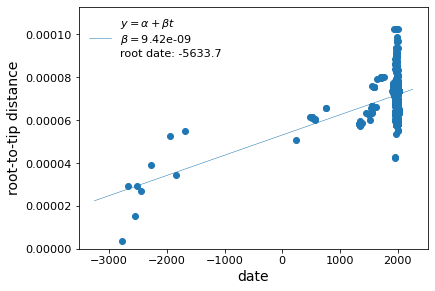

In [9]:
tt = treetime.TreeTime(dates=dates, 
                           aln=aln_path,                     
                           tree=tree_path, 
                           verbose=4, 
                           fill_overhangs=False,
                           seq_len=REF_LEN,                        
                          )

# Confirm that outliers have already been removed
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=True,
                )

# Check rtt
print("Clock Model: ", tt.date2dist.__dict__)

In [10]:
# Initialize stdout capture
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

# PARAM MIN: root='-4101-09-02'
#tt.run()


# PARAM FULL: root=''
tt.run(
       Tc=TC, 
       max_iter=MAX_ITER,
       relaxed_clock={"slack":5.0, "coupling": 0},
       infer_gtr=True,
       time_marginal=TIME_MARGINAL,
       sequence_marginal=SEQ_MARGINAL,
       verbose=4,
       resolve_polytomies=False,
       n_iqd=N_IQD,
       #branch_length_mode = "input",
       # root=None,
       # use_covariation=False,
       # vary_rate=False,
       )

# Save stdout to file
output = new_stdout.getvalue()
out_path = os.path.join(outdir, SCRIPT_NAME + ".log") 
with open(out_path, "w") as file:
    file.write(output)
    
# Restore stdout
sys.stdout = old_stdout
print("Standard output restored.")

Standard output restored.


In [11]:
# Quick check 1
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch=2.148814885614286e-07, branch_length=0.0, clock_length=0.0, date='-4728-03-09', dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

In [12]:
# Quick check 2
tt.clock_model

{'slope': 8.726140396690818e-09,
 'intercept': 4.645370560586682e-05,
 'chisq': 2.015325515504353e-08,
 'hessian': array([[2.39280702e+09, 1.17738700e+06],
        [1.17738700e+06, 6.30000000e+02]]),
 'r_val': 0.5163390408175497,
 'valid_confidence': False}

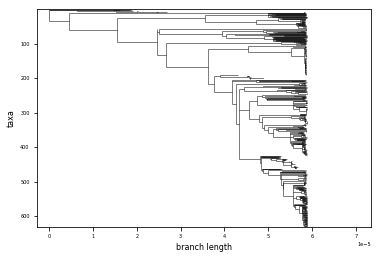

In [13]:
# Quick check 3
Phylo.draw(tt.tree, 
       show_confidence=False, 
       label_func = lambda x:'', 
       do_show=False)

## Ladderize Tree

In [14]:
tt.tree.ladderize(reverse=False)

---
# 2. Add clock stats to data frame

- Rates
- Dates
- RTT Regression
- Skyline

## Rates

In [15]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [80]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Optional confidence intervals if marginal prob was run
tree_df["timetree_num_date_confidence"] = [[0,0] for row in range(0,len(tree_df))]  

# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):    
        # Retrieve the region containing the confidence interval
        #conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        #peak = tt.date2dist.to_numdate(c.marginal_pos_LH.peak_pos)
        #print(c.name, c.branch_length, c.clock_length)
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    # Joint Likelihood dates
    #if not TIME_MARGINAL:
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length
    #else:
    #    tree_df.at[c.name, "timetree_num_date"] = peak
    #    tree_df.at[c.name, "timetree_clock_length"] = peak

1996.42	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years
NODE0 0.1
SAMEA3541827 1851.8163981867938
NODE1 721.2731944320512
SAMEA104233046 1385.5432037547425
NODE2 966.7325621788059
SAMEA104233047 474.7691985819192
NODE3 44.171370036161534
NODE4 428.0678501879611
SAMEA6812876 24.628121399618976
SAMEA6812877 0.0
NODE5 553.1649459067876
SAMEA104233049 46.47432563298753
NODE6 516.4908485303456
SAMEA104233048 43.983477102642155
SAMEA3541826 290.476467665394
NODE7 508.2451741875675
NODE8 6168.844498806215
GCA_000323485.1_ASM32348v1_genomic 12.726610594809245
GCA_000323845.1_ASM32384v1_genomic 11.726610594809245
NODE9 1265.354840317461
NODE10 2309.26406527936
NODE11 1649.1574148914615
GCA_001294825.1_ASM129482v1_genomic 979.794788912742
GCA_006376585.1_ASM637658v1_genomic 973.794788912742
NODE13 69.70343984815577
GCA_001601675.1_ASM160167v1_genomic 925.0913490645862
GCA_002127375.1_ASM212737v1_genomic 924.0913490645862
NODE17 171.0326792447447
GCA_0021273

NODE139 13.971447674168985
GCA_009670325.1_ASM967032v1_genomic 31.174846560159267
GCA_009670865.1_ASM967086v1_genomic 16.174846560159267
GCA_009667885.1_ASM966788v1_genomic 31.174846560159267
GCA_009670355.1_ASM967035v1_genomic 31.174846560159267
NODE143 6.733662733963683
GCA_009669705.1_ASM966970v1_genomic 24.441183826195584
GCA_009670995.1_ASM967099v1_genomic 5.441183826195584
NODE144 17.174961158361384
GCA_009670725.1_ASM967072v1_genomic 1.9998854017978829
GCA_009670815.1_ASM967081v1_genomic -0.00011459820211712213
NODE147 17.174961158361384
GCA_009670005.1_ASM967000v1_genomic 22.999885401797883
GCA_009670705.1_ASM967070v1_genomic -0.00011459820211712213
GCA_009669765.1_ASM966976v1_genomic 10.999885401797883
GCA_009670465.1_ASM967046v1_genomic 11.999885401797883
NODE150 22.174961158361384
GCA_009670625.1_ASM967062v1_genomic 5.999885401797883
GCA_009670775.1_ASM967077v1_genomic -0.00011459820211712213
GCA_009670575.1_ASM967057v1_genomic 5.999885401797883
GCA_009670715.1_ASM967071v1_g

NODE282 353.2565806667608
GCA_015158815.1_ASM1515881v1_genomic 3.9998854017981103
GCA_015158715.1_ASM1515871v1_genomic -0.00011459820188974845
GCA_015158935.1_ASM1515893v1_genomic 3.9998854017981103
NODE268 343.885535671694
GCA_000323345.1_ASM32334v1_genomic 1.3709303968648783
GCA_000324125.1_ASM32412v1_genomic 1.3709303968648783
GCA_015158845.1_ASM1515884v1_genomic 12.370930396864878
GCA_015158765.1_ASM1515876v1_genomic 13.370930396864878
GCA_015158895.1_ASM1515889v1_genomic 13.370930396864878
NODE273 6.371044995066995
GCA_015159075.1_ASM1515907v1_genomic -0.00011459820211712213
GCA_015159105.1_ASM1515910v1_genomic 1.9998854017978829
NODE274 30.405472367195216
GCA_000323305.1_ASM32330v1_genomic 286.8509937013637
NODE279 284.5946104017555
GCA_000323325.1_ASM32332v1_genomic 24.25638329960816
NODE280 41.25649789781028
GCA_015158675.1_ASM1515867v1_genomic -0.00011459820211712213
GCA_015158805.1_ASM1515880v1_genomic 0.9998854017978829
NODE275 37.790786285749164
NODE276 196.84516466189893
G

NODE413 15.301502883630747
GCA_001617815.1_Yersinia_pestis_M-1453_genomic 86.5229483837245
GCA_008630395.1_ASM863039v1_genomic 79.5229483837245
NODE415 66.29623838301904
GCA_003085855.1_ASM308585v1_genomic 31.226710000705452
GCA_016102965.1_ASM1610296v1_genomic 19.226710000705452
NODE417 24.724525319382792
GCA_008630575.1_ASM863057v1_genomic 54.798423064341705
NODE419 16.369453106224
GCA_016102905.1_ASM1610290v1_genomic 40.428969958117705
GCA_001613885.1_ASM161388v1_genomic 44.428969958117705
GCA_001617705.1_Yersinia_pestis_C-791_genomic 57.428969958117705
NODE421 34.16884070470974
NODE425 18.142922275456385
GCA_001595585.1_ASM159558v1_genomic 27.486660084175583
GCA_003085995.1_ASM308599v1_genomic 32.48666008417558
NODE426 14.374489588911956
GCA_008630485.1_ASM863048v1_genomic 19.25509277072001
GCA_016102915.1_ASM1610291v1_genomic 21.25509277072001
NODE422 50.629696957834085
GCA_003086055.1_ASM308605v1_genomic -0.00011459820211712213
GCA_015336695.1_ASM1533669v1_genomic 0.9998854017978

NODE578 35.865761935076534
GCA_000268465.1_ASM26846v1_genomic 89.4231495289248
GCA_000268545.1_ASM26854v1_genomic 87.4231495289248
NODE574 13.687709541102095
GCA_000268505.1_ASM26850v1_genomic 112.60120192289924
NODE575 28.00890900886361
GCA_000268325.1_ASM26832v1_genomic 81.59229291403562
GCA_000268345.1_ASM26834v1_genomic 81.59229291403562
NODE582 15.579465219535223
NODE584 43.02032294525179
GCA_000268405.1_ASM26840v1_genomic 64.68912329921432
GCA_000268445.1_ASM26844v1_genomic 64.68912329921432
NODE586 39.18637326493058
GCA_000268385.1_ASM26838v1_genomic 68.52307297953553
GCA_000268425.1_ASM26842v1_genomic 68.52307297953553
NODE587 70.30229733290093
GCA_000268625.1_ASM26862v1_genomic 39.40714891156517
NODE588 28.34441522078032
GCA_000268585.1_ASM26858v1_genomic 9.062733690784853
GCA_000268825.1_ASM26882v1_genomic 13.062733690784853
NODE589 12.035975811553044
GCA_000269065.1_ASM26906v1_genomic 99.67347043291306
NODE594 99.67358503111518
GCA_000268805.1_ASM26880v1_genomic -0.000114598

In [17]:
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_clock_length
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,5.504755e-08,0.PRE,0.998934,8.392601e-03,0.PRE2,0.392459,1.313666e+00,Russia,0.993980,3.949705e-02,64.686314,97.745306,Krasnoyarsk Krai,0.384682,1.597786e+00,63.323381,97.097997,8.72614e-09,1,0,-4728-03-09,-4727.82,"[-5052.15452320081, -4517.214843377424]",0.1
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,0,1.0,-1.000089e-12,0.PRE,1.000000,-9.998669e-13,0.PRE2,1.000000,-1.000089e-12,Russia,1.000000,-1.000089e-12,64.686314,97.745306,Krasnoyarsk Krai,1.000000,-1.000089e-12,63.323381,97.097997,1.99344e-09,0.228444,3.22496e-06,-2876-01-01,-2876,"[-2876.0, -2677.0]",1851.82
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,5.504751e-08,0.PRE,0.999999,1.683836e-05,0.PRE1,0.999341,6.184421e-03,Russia,0.983371,1.064486e-01,64.686314,97.745306,Panevezys County,0.445993,1.859914e+00,55.915605,25.031160,1.08332e-08,1.24147,8.39191e-06,-4007-06-16,-4006.54,"[-4242.450942437016, -3792.8169361444525]",721.273
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,0,1.0,-9.998669e-13,0.PRE,1.000000,-9.998669e-13,0.PRE1,1.000000,-1.000089e-12,Lithuania,1.000000,-1.000089e-12,55.350000,23.750000,Panevezys County,1.000000,-9.998669e-13,55.915605,25.031160,1.72041e-09,0.197156,1.93515e-06,-2621-01-01,-2621,"[-2621.0, -2479.9053159960413]",1385.54
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,5.504755e-08,0.PRE,1.000000,1.288735e-07,0.PRE1,0.999999,1.201571e-05,Russia,0.982836,1.110024e-01,64.686314,97.745306,Pärnu maakond,0.445905,1.854285e+00,58.319507,24.302612,1.4399e-08,1.6501,1.42178e-05,-3040-03-11,-3039.81,"[-3261.1543756098254, -2937.2892908244467]",966.733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1,1.0,5.143267e-08,1.ORI,1.000000,1.245663e-07,1.ORI1,1.000000,5.875390e-07,Peru,0.999999,1.204163e-05,-6.869970,-75.045851,La Libertad,0.999925,7.984780e-04,-8.000000,-78.500000,NA,NA,NA,NA,NA,"[0, 0]",NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1,1,1.0,-1.000089e-12,1.ORI,1.000000,-9.998669e-13,1.ORI1,1.000000,-1.000089e-12,Peru,1.000000,-9.998669e-13,-6.869970,-75.045851,La Libertad,1.000000,-9.998669e-13,-8.000000,-78.500000,6.13657e-09,0.70324,2.14892e-07,2010-01-01,2010,"[2010.0, 2010.0]",72.9664
NODE631,37,49.6,2.93

## Regression

In [18]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

602.76	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,5.504755e-08,0.PRE,0.998934,8.392601e-03,0.PRE2,0.392459,1.313666e+00,Russia,0.993980,3.949705e-02,64.686314,97.745306,Krasnoyarsk Krai,0.384682,1.597786e+00,63.323381,97.097997,8.72614e-09,1,0,-4728-03-09,-4727.82,"[-5052.15452320081, -4517.214843377424]",0.1,0.1,17.9492,-4727.82,0,False
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,0,1.0,-1.000089e-12,0.PRE,1.000000,-9.998669e-13,0.PRE2,1.000000,-1.000089e-12,Russia,1.000000,-1.000089e-12,64.686314,97.745306,Krasnoyarsk Krai,1.000000,-1.000089e-12,63.323381,97.097997,1.99344e-09,0.228444,3.22496e-06,-2876-01-01,-2876,"[-2876.0, -2677.0]",1851.82,1851.92,1,-2776.5,3.22496e-06,False
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,5.504751e-08,0.PRE,0.999999,1.683836e-05,0.PRE1,0.999341,6.184421e-03,Russia,0.983371,1.064486e-01,64.686314,97.745306,Panevezys County,0.445993,1.859914e+00,55.915605,25.031160,1.08332e-08,1.24147,8.39191e-06,-4007-06-16,-4006.54,"[-4242.450942437016, -3792.8169361444525]",721.273,721.373,3.15625,-4006.54,8.39191e-06,False
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,0,1.0,-9.998669e-13,0.PRE,1.000000,-9.998669e-13,0.PRE1,1.000000,-1.000089e-12,Lithuania,1.000000,-1.000089e-12,55.350000,23.750000,Panevezys County,1.000000,-9.998669e-13,55.915605,25.031160,1.72041e-09,0.197156,1.93515e-06,-2621-01-01,-2621,"[-2621.0, -2479.9053159960413]",1385.54,2106.92,2,-2546.5,1.03271e-05,False
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,5.504755e-08,0.PRE,1.000000,1.288735e-07,0.PRE1,0.999999,1.201571e-05,Russia,0.982836,1.110024e-01,64.686314,97.745306,Pärnu maakond,0.445905,1.854285e+00,58.319507,24.302612,1.4399e-08,1.6501,1.42178e-05,-3040-03-11,-3039.81,"[-3261.1543756098254, -2937.2892908244467]",966.733,1688.11,4.3125,-3039.81,2.26097e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1,1.0,5.143267e-08,1.ORI,1.000000,1.245663e-07,1.ORI1,1.000000,5.875390e-07,Peru,0.999999,1.204163e-05,-6.869970,-75.045851,La Libertad,0.999925,7.984780e-04,-8.000000,-78.500000,NA,NA,NA,NA,NA,"[0, 0]",NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141

## Skyline

In [19]:
if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    print(skyline)
    print(conf)

---
# 3. Export

## Tree and Dataframe

In [20]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [21]:
"""
# For reloading
import importlib
import sys
importlib.reload(sys.modules['config'])
from config import augur_export
"""

augur_dict = augur_export(
    tree_path=tree_path, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': '1992.0', 'datebp': '-29.0', 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'branch_number_confidence': {'1': 1.0}, 'branch_number_entropy': -1.000088900581841e-12, 'branch_major_confidence': {'1.ORI': 1.0}, 'branch_major_entropy': -1.000088900581841e-12, 'branch_minor_confidence': {'1.ORI1': 1.0}, 'branch_minor_entropy': -9.99866855976916e-13, 'country_confidence': {'United States of America': 1.0}, 'country_entropy': -1.000088900581841e-12, 'province_confidence': {'Colorado': 1.0}, 'province_entropy': -1.000088900581841e-12, 'rate': 1.1131990793551299e-08, 'rate_fold_change': 1.2757061297997043, 'mutation_length': 1.7201601415845434e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'num_date_confidence': [1992.0, 1992

### Add clock model

In [22]:
clock_model_dict = {
    "rate" : tt.date2dist.clock_rate,
    "intercept" : tt.date2dist.intercept,
    "rtt_Tmrca" : -tt.date2dist.intercept/tt.date2dist.clock_rate,
    
}

augur_dict["clock"] = clock_model_dict

### Add skyline

In [23]:
if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

In [24]:
print(augur_dict["nodes"]["Reference"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': '1992.0', 'datebp': '-29.0', 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'branch_number_confidence': {'1': 1.0}, 'branch_number_entropy': -1.000088900581841e-12, 'branch_major_confidence': {'1.ORI': 1.0}, 'branch_major_entropy': -1.000088900581841e-12, 'branch_minor_confidence': {'1.ORI1': 1.0}, 'branch_minor_entropy': -9.99866855976916e-13, 'country_confidence': {'United States of America': 1.0}, 'country_entropy': -1.000088900581841e-12, 'province_confidence': {'Colorado': 1.0}, 'province_entropy': -1.000088900581841e-12, 'rate': 1.1131990793551299e-08, 'rate_fold_change': 1.2757061297997043, 'mutation_length': 1.7201601415845434e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'num_date_confidence': [1992.0, 1992

## Auspice JSON

Manual edits of https://github.com/nextstrain/augur/blob/master/augur/export_v2.py

This can then be used for auspice via:

```
HOST="localhost" auspice view --datasetDir .
```

In [25]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

Validating schema of '../../config/auspice_config.json'...
Validation success.
Validating produced JSON
Validating schema of '../../docs/results/latest/timetree/timetree_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../docs/results/latest/timetree/timetree_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_timetree.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_timetree.json' succeeded.
Validation successful for remote JSON.


## Skyline

In [26]:
if hasattr(tt, "merger_model"):
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )

    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

